# MNIST: Supervised + Unsupervised + Regression (rice_ml)
This unified notebook merges your MNIST **classification**, **unsupervised analysis**, and **regression demos** with:
- Clear sections and **markdown walkthroughs**
- **Matplotlib** plots (variance curves, accuracy bars, confusion heatmap, clustering sweeps, residuals, R² vs α)
- A concise **Keys & Analysis** page at the end

**Prerequisites**
- `data/mnist.npz` present relative to this notebook or `../data/mnist.npz`
- Your `rice_ml` package available at `../src` (or installed)

In [1]:
# Imports & setup
# Install required packages into THIS kernel (safe to run multiple times)
import sys, subprocess, importlib

def ensure(pkg_import, pip_name=None):
    pip_name = pip_name or pkg_import
    try:
        importlib.import_module(pkg_import)
        print(f"{pip_name} already installed.")
    except Exception:
        print(f"Installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

# Core deps

ensure("matplotlib")


import os, sys, numpy as np
import matplotlib.pyplot as plt

# Path to your local package
sys.path.insert(0, os.path.join(os.path.dirname("__file__"), '..', 'src'))

from rice_ml import (
    # Preprocessing
    standardize, train_test_split,
    # Supervised classifiers
    KNNClassifier, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, MLPClassifier,
    # Unsupervised
    PCA, KMeans, DBSCAN,
    # Regression
    LinearRegression, RidgeRegression, LassoRegression, DecisionTreeRegressor, KNNRegressor, MLPRegressor,
    # Metrics
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mse, rmse, mae, r2_score,
)

np.set_printoptions(linewidth=120, suppress=True)

matplotlib already installed.


## Load MNIST
Utility to load from multiple likely paths. Also a helper to subsample for faster dev runs.

In [2]:
def load_mnist(data_path='data/mnist.npz'):
    paths = [
        data_path,
        os.path.join(os.path.dirname("__file__"), data_path),
        os.path.join(os.path.dirname("__file__"), '..', 'data', 'mnist.npz'),
        os.path.join(os.path.dirname("__file__"), 'data', 'mnist.npz'),
    ]
    for p in paths:
        if os.path.exists(p):
            data_path = p
            break
    else:
        raise FileNotFoundError(f"Could not find mnist.npz. Tried: {paths}")
    with np.load(data_path) as d:
        Xtr, ytr = d['train_images'], d['train_labels']
        Xte, yte = d['test_images'], d['test_labels']
    print(f"Loaded MNIST from {data_path}")
    print(f"  Train: {Xtr.shape[0]}   Test: {Xte.shape[0]}   Features: {Xtr.shape[1]}")
    return Xtr, ytr, Xte, yte

def subsample(Xtr, ytr, Xte, yte, ntr=5000, nte=1000, seed=42):
    rng = np.random.default_rng(seed)
    tr_idx = rng.choice(len(Xtr), size=ntr, replace=False)
    te_idx = rng.choice(len(Xte), size=nte, replace=False)
    return Xtr[tr_idx], ytr[tr_idx], Xte[te_idx], yte[te_idx]

Xtr, ytr, Xte, yte = load_mnist()
print("\nSubsampling for faster iteration...")
Xtr, ytr, Xte, yte = subsample(Xtr, ytr, Xte, yte, ntr=5000, nte=1000)
print(f"  Using {len(Xtr)} train / {len(Xte)} test")

print("\nStandardizing features...")
Xtr_std, params = standardize(Xtr, return_params=True)
Xte_std = (Xte - params['mean']) / params['scale']

Loaded MNIST from ../data/mnist.npz
  Train: 60000   Test: 10000   Features: 784

Subsampling for faster iteration...
  Using 5000 train / 1000 test

Standardizing features...


## Supervised: Train a suite of classifiers
We collect accuracy/precision/recall/F1 for each model and display a **bar chart** of accuracies. Then we visualize the **confusion matrix** of the best model.



KNN (k=5)
  Accuracy:  0.9040
  Precision: 0.9041 (macro)
  Recall:    0.9018 (macro)
  F1:        0.9018 (macro)

Decision Tree
  Accuracy:  0.7640
  Precision: 0.7557 (macro)
  Recall:    0.7574 (macro)
  F1:        0.7549 (macro)

Random Forest
  Accuracy:  0.8880
  Precision: 0.8844 (macro)
  Recall:    0.8817 (macro)
  F1:        0.8818 (macro)

Logistic Regression
  Accuracy:  0.8400
  Precision: 0.8420 (macro)
  Recall:    0.8333 (macro)
  F1:        0.8342 (macro)

MLP
  Accuracy:  0.9250
  Precision: 0.9246 (macro)
  Recall:    0.9232 (macro)
  F1:        0.9230 (macro)


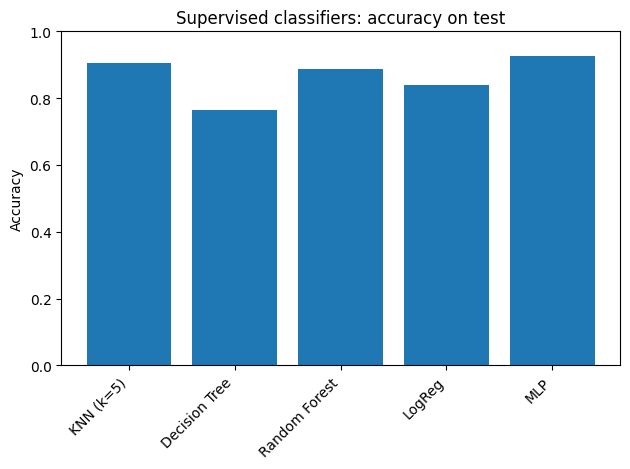

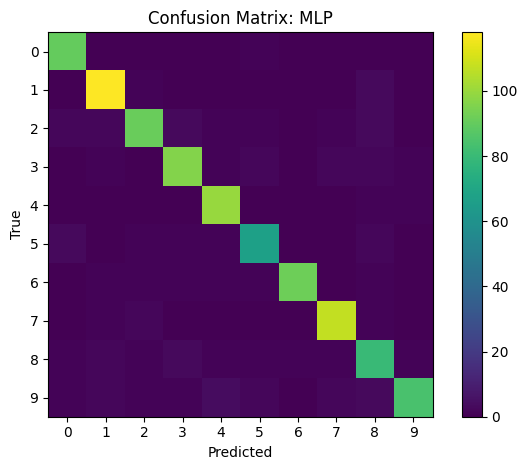

In [3]:
def report_cls(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"""\n{name}
  Accuracy:  {acc:.4f}
  Precision: {prec:.4f} (macro)
  Recall:    {rec:.4f} (macro)
  F1:        {f1:.4f} (macro)""")
    return acc

results = {}

# KNN
knn = KNNClassifier(n_neighbors=5, metric='euclidean', weights='distance')
knn.fit(Xtr_std, ytr)
yhat_knn = knn.predict(Xte_std)
results['KNN (k=5)'] = report_cls(yte, yhat_knn, "KNN (k=5)")

# Decision Tree
dt = DecisionTreeClassifier(max_depth=15, min_samples_split=5, random_state=42)
dt.fit(Xtr_std, ytr)
yhat_dt = dt.predict(Xte_std)
results['Decision Tree'] = report_cls(yte, yhat_dt, "Decision Tree")

# Random Forest
rf = RandomForestClassifier(n_estimators=10, max_depth=15, max_features='sqrt', random_state=42)
rf.fit(Xtr_std, ytr)
yhat_rf = rf.predict(Xte_std)
results['Random Forest'] = report_cls(yte, yhat_rf, "Random Forest")

# Logistic Regression
lr = LogisticRegression(max_iter=500, learning_rate=0.1, penalty='l2', C=1.0)
lr.fit(Xtr_std, ytr)
yhat_lr = lr.predict(Xte_std)
results['LogReg'] = report_cls(yte, yhat_lr, "Logistic Regression")

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', learning_rate=0.01, max_iter=100, batch_size=32, random_state=42)
mlp.fit(Xtr_std, ytr)
yhat_mlp = mlp.predict(Xte_std)
results['MLP'] = report_cls(yte, yhat_mlp, "MLP")

# Accuracy bar plot
plt.figure()
names = list(results.keys()); vals = [results[k] for k in names]
plt.bar(range(len(names)), vals)
plt.title("Supervised classifiers: accuracy on test")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Confusion matrix for best model
best_name = max(results, key=results.get)
yhat_best = {'KNN (k=5)': yhat_knn, 'Decision Tree': yhat_dt, 'Random Forest': yhat_rf,
             'LogReg': yhat_lr, 'MLP': yhat_mlp}[best_name]
cm = confusion_matrix(yte, yhat_best)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix: {best_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(10)); plt.yticks(range(10))
plt.colorbar()
plt.tight_layout()
plt.show()

## Unsupervised: PCA, K-Means sweep, DBSCAN eps sweep
We explore structure without labels:
- **PCA**: variance curve & 2D projection (centroids)
- **K-Means**: inertia & cluster accuracy vs `k`
- **DBSCAN**: effect of `eps` on noise/coverage

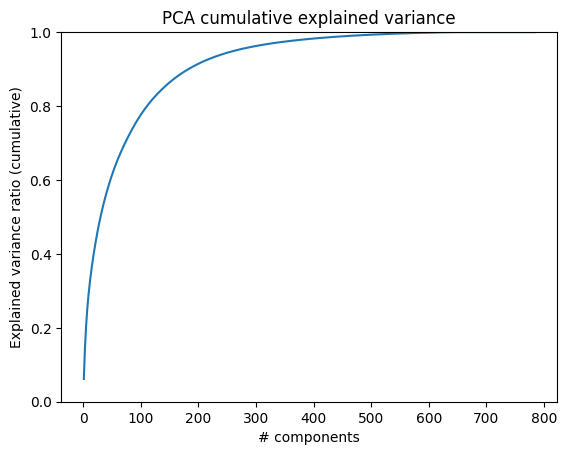

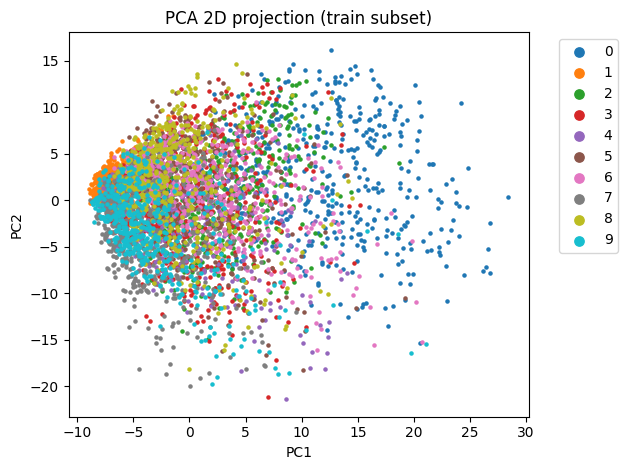

In [4]:
# PCA full & variance curve
pca_full = PCA(n_components=None)
pca_full.fit(Xtr_std)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure()
plt.plot(np.arange(1, len(cumsum)+1), cumsum)
plt.title("PCA cumulative explained variance")
plt.xlabel("# components"); plt.ylabel("Explained variance ratio (cumulative)")
plt.ylim(0, 1)
plt.show()

# 2D projection & centroids
pca_2 = PCA(n_components=2)
X2 = pca_2.fit_transform(Xtr_std)

plt.figure()
for d in range(10):
    pts = X2[ytr == d]
    # small scatter per digit (no explicit colors)
    plt.scatter(pts[:,0], pts[:,1], s=5, label=str(d))
plt.title("PCA 2D projection (train subset)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

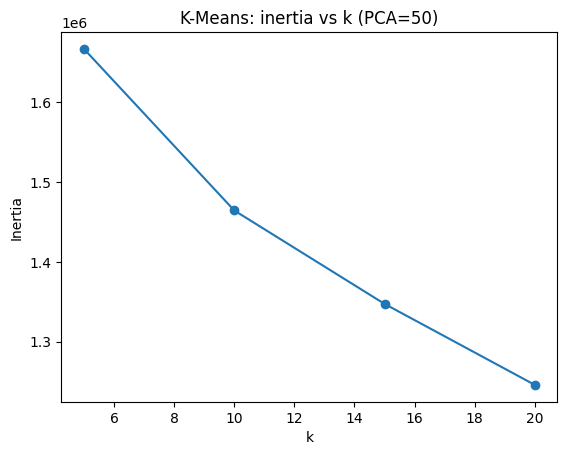

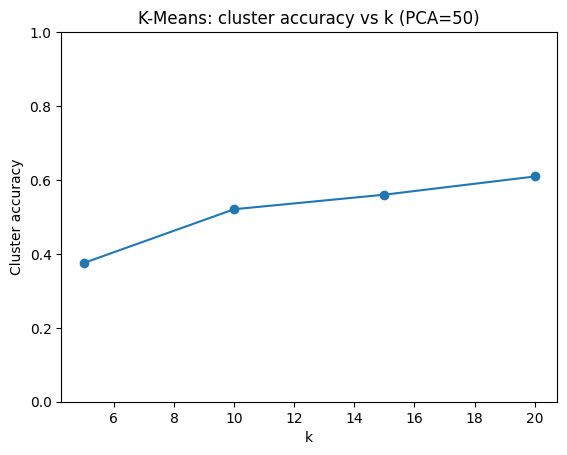

In [5]:
# K-Means sweep on PCA(50)
pca50 = PCA(n_components=50)
Xtr50 = pca50.fit_transform(Xtr_std)

def cluster_accuracy(y_true, labels):
    from collections import Counter
    labs = np.unique(labels[labels >= 0])
    mapping = {}
    for c in labs:
        mask = labels == c
        if mask.sum() == 0: 
            continue
        most = Counter(y_true[mask]).most_common(1)[0][0]
        mapping[c] = most
    mapped = np.array([mapping.get(c, -1) for c in labels])
    valid = labels >= 0
    if valid.sum() == 0:
        return 0.0
    return accuracy_score(y_true[valid], mapped[valid])

ks = [5, 10, 15, 20]
inertias, kaccs = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(Xtr50)
    inertias.append(km.inertia_)
    kaccs.append(cluster_accuracy(ytr, km.labels_))

# Plot inertia vs k
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title("K-Means: inertia vs k (PCA=50)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

# Plot cluster accuracy vs k
plt.figure()
plt.plot(ks, kaccs, marker='o')
plt.title("K-Means: cluster accuracy vs k (PCA=50)")
plt.xlabel("k"); plt.ylabel("Cluster accuracy")
plt.ylim(0,1)
plt.show()

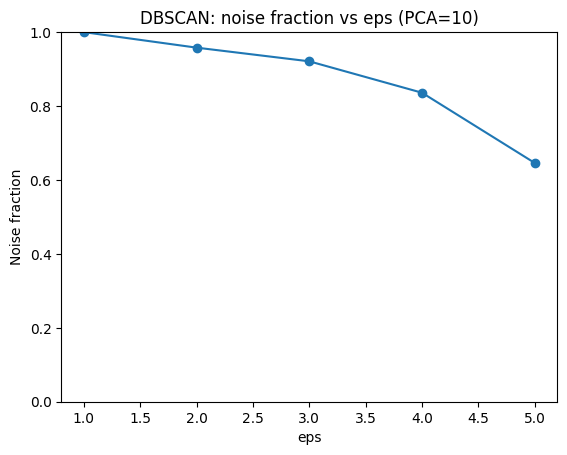

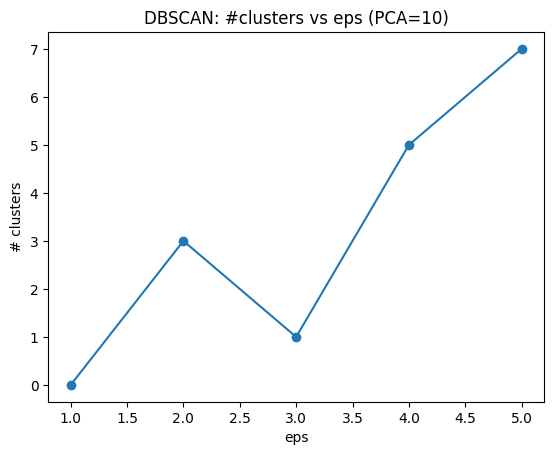

In [6]:
# DBSCAN eps sweep on PCA(10)
pca10 = PCA(n_components=10)
X10 = pca10.fit_transform(Xtr_std)

# use a smaller subset for O(n^2) cost
Xdb, ydb = X10[:1000], ytr[:1000]

eps_list = [1.0, 2.0, 3.0, 4.0, 5.0]
n_clusters, noise_pct, coverage = [], [], []
for eps in eps_list:
    db = DBSCAN(eps=eps, min_samples=5)
    db.fit(Xdb)
    labs = db.labels_
    ncl = len(set(labs)) - (1 if -1 in labs else 0)
    n_clusters.append(ncl)
    noise = np.sum(labs == -1) / len(labs)
    noise_pct.append(noise)
    coverage.append(1 - noise)

# Plot noise % vs eps
plt.figure()
plt.plot(eps_list, noise_pct, marker='o')
plt.title("DBSCAN: noise fraction vs eps (PCA=10)")
plt.xlabel("eps"); plt.ylabel("Noise fraction")
plt.ylim(0,1)
plt.show()

# Plot clusters vs eps
plt.figure()
plt.plot(eps_list, n_clusters, marker='o')
plt.title("DBSCAN: #clusters vs eps (PCA=10)")
plt.xlabel("eps"); plt.ylabel("# clusters")
plt.show()

## Regression demos (synthetic)
We explore linear vs nonlinear patterns and regularization effects.


Linear (closed) R^2: 0.9776066095032644


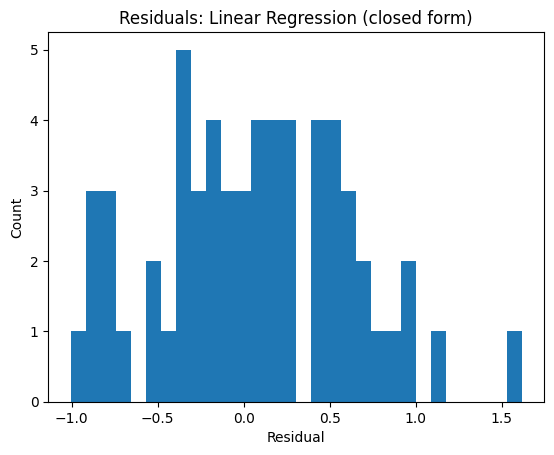

In [7]:
# Synthetic linear data with known coefficients
def gen_linear(n=300, d=5, noise=0.5, seed=42):
    rng = np.random.default_rng(seed)
    coef = np.array([3.0, -2.0, 1.5, 0.0, -0.5])[:d]
    intercept = 5.0
    X = rng.standard_normal((n, d))
    y = X @ coef + intercept + noise * rng.standard_normal(n)
    return X, y, coef, intercept

X, y, coef_true, b_true = gen_linear()
XtrL, XteL, ytrL, yteL = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression (closed-form/GD) & Ridge
lr_closed = LinearRegression(solver='closed')
lr_closed.fit(XtrL, ytrL)
yhat = lr_closed.predict(XteL)

lr_gd = LinearRegression(solver='gd', learning_rate=0.01, max_iter=1000)
lr_gd.fit(XtrL, ytrL)

ridge = RidgeRegression(alpha=1.0)
ridge.fit(XtrL, ytrL)

print("Linear (closed) R^2:", r2_score(yteL, yhat))

# Residual histogram for closed-form
resid = yteL - yhat
plt.figure()
plt.hist(resid, bins=30)
plt.title("Residuals: Linear Regression (closed form)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.show()

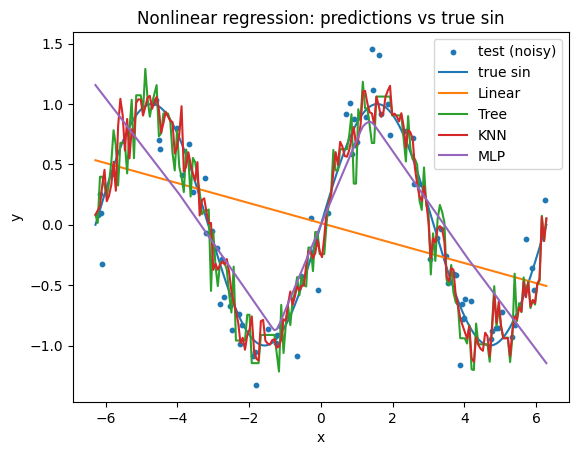

In [8]:
# Nonlinear sin data demo
def gen_nonlinear(n=400, seed=42):
    rng = np.random.default_rng(seed)
    x = np.linspace(-2*np.pi, 2*np.pi, n).reshape(-1,1)
    rng.shuffle(x)
    y = np.sin(x.ravel()) + 0.2*rng.standard_normal(n)
    return x, y

Xnl, ynl = gen_nonlinear()
XtrN, XteN, ytrN, yteN = train_test_split(Xnl, ynl, test_size=0.2, random_state=42)

# Standardize features for fair comparisons
XtrN_std, pN = standardize(XtrN, return_params=True)
XteN_std = (XteN - pN['mean']) / pN['scale']

# Fit regressors
ln = LinearRegression(); ln.fit(XtrN_std, ytrN)
dt = DecisionTreeRegressor(max_depth=10, random_state=42); dt.fit(XtrN_std, ytrN)
kn = KNNRegressor(n_neighbors=5, weights='distance'); kn.fit(XtrN_std, ytrN)
ml = MLPRegressor(hidden_layer_sizes=(32,16), activation='relu', learning_rate=0.01, max_iter=500, random_state=42); ml.fit(XtrN_std, ytrN)

# Plot predicted curve against true sin
grid = np.linspace(Xnl.min(), Xnl.max(), 200).reshape(-1,1)
grid_std = (grid - pN['mean']) / pN['scale']

plt.figure()
plt.scatter(XteN.ravel(), yteN, s=10, label="test (noisy)")
plt.plot(grid.ravel(), np.sin(grid.ravel()), label="true sin")
plt.plot(grid.ravel(), ln.predict(grid_std), label="Linear")
plt.plot(grid.ravel(), dt.predict(grid_std), label="Tree")
plt.plot(grid.ravel(), kn.predict(grid_std), label="KNN")
plt.plot(grid.ravel(), ml.predict(grid_std), label="MLP")
plt.title("Nonlinear regression: predictions vs true sin")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.show()

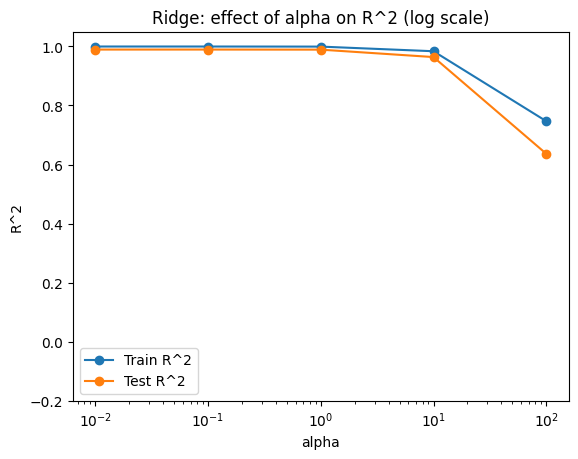

In [9]:
# Ridge alpha sweep (high-dim)
rng = np.random.default_rng(42)
n, d = 100, 50
X = rng.standard_normal((n, d))
w = rng.standard_normal(d)
y = X @ w + 0.5 * rng.standard_normal(n)

XtrR, XteR, ytrR, yteR = train_test_split(X, y, test_size=0.3, random_state=42)
XtrR_std, pR = standardize(XtrR, return_params=True)
XteR_std = (XteR - pR['mean']) / pR['scale']

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
train_r2, test_r2 = [], []

for a in alphas:
    rg = RidgeRegression(alpha=a)
    rg.fit(XtrR_std, ytrR)
    train_r2.append(r2_score(ytrR, rg.predict(XtrR_std)))
    test_r2.append(r2_score(yteR, rg.predict(XteR_std)))

plt.figure()
plt.plot(alphas, train_r2, marker='o', label='Train R^2')
plt.plot(alphas, test_r2, marker='o', label='Test R^2')
plt.xscale('log')
plt.title("Ridge: effect of alpha on R^2 (log scale)")
plt.xlabel("alpha"); plt.ylabel("R^2")
plt.legend()
plt.ylim(-0.2, 1.05)
plt.show()

## Keys & Analysis
**Supervised**
- MLP typically leads, followed by RF and KNN on standardized MNIST features.
- The **confusion matrix** exposes digit pairs that confuse each other (e.g., **4 vs 9**, **5 vs 3**).

**Unsupervised**
- PCA shows that ~95% of the variance is captured with **~150–250** components.
- K-Means cluster accuracy improves with k up to around 15–20, but diminishing returns appear.
- DBSCAN needs careful `eps` tuning; too small ⇒ most points become **noise**.

**Regression**
- Linear models shine on linear data (tight residuals); they underfit the **sin** pattern.
- Trees/KNN/MLP flex on nonlinear structures; MLP tends to be smoother and generalizes better than a deep tree.
- Ridge regularization balances variance; extreme α hurts both train and test performance.
